[View in Colaboratory](https://colab.research.google.com/github/ozanpekmezci/capstone/blob/master/prepare_svhn.ipynb)

# Prepare SVHN Dataset
This notebook serves to download and preprocess SVHN data, which will be used by other notebooks to classify street numbers.
## Download, Extraction & Preprocess SVHN Data


In [0]:
# These are all the modules we'll be using later.
from __future__ import print_function
import numpy as np

from six.moves import cPickle as pickle
from six.moves import range

import os
import sys
import tarfile
from IPython.display import display, Image

import h5py

import matplotlib.pyplot as plt

from PIL import Image
import random
from urllib import urlretrieve

In [0]:
from collections import Counter

In [0]:
%matplotlib inline

### Download dataset 

In [4]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

train_filename = maybe_download('train.tar.gz', 404141560 )
test_filename = maybe_download('test.tar.gz', 276555967 )

Attempting to download: train.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified train.tar.gz
Attempting to download: test.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified test.tar.gz


### Extracting Data

In [5]:
num_classes = 10
np.random.seed(133)

train_filename = 'train.tar.gz'
test_filename = 'test.tar.gz'
# extra_filename = 'extra.tar.gz'

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    if not os.path.exists(root+'/digitStruct.mat'):
        print("digitStruct.mat is missing")
    return root + '/digitStruct.mat'
  
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for train. This may take a while. Please wait.
Extracting data for test. This may take a while. Please wait.


### Read the dataset

In [6]:
print(train_folders)

train/digitStruct.mat


In [0]:
train_dataset = h5py.File(train_folders, "r")

In [8]:
train_dataset["digitStruct"].items()

[(u'bbox', <HDF5 dataset "bbox": shape (33402, 1), type "|O">),
 (u'name', <HDF5 dataset "name": shape (33402, 1), type "|O">)]

In [0]:
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label']  = pictDat[i]['label'][j]
                figure['left']   = pictDat[i]['left'][j]
                figure['top']    = pictDat[i]['top'][j]
                figure['width']  = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [10]:
print(train_folders)
train = DigitStructFile(train_folders)
train_data = train.getAllDigitStructure_ByDigit()


test = DigitStructFile(test_folders)
test_data = test.getAllDigitStructure_ByDigit()

train/digitStruct.mat


In [11]:
train_data[0]

{'boxes': [{'height': 219.0,
   'label': 1.0,
   'left': 246.0,
   'top': 77.0,
   'width': 81.0},
  {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}],
 'filename': '1.png'}

In [0]:
# save digitStruct information 
pickle_file = 'multi_bbox_info.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_data': train_data,
    'test_data': test_data,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [13]:
pickle_file = 'multi_bbox_info.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_data = save['train_data']
    test_data = save['test_data']
    del save
    print('Training set', len(train_data))
    print('Test set', len(test_data))

Training set 33402
Test set 13068


### Generate dataset

In [0]:
class Dataset:
    """crop images and save them to numpy ndarray"""
    
    def __init__(self, digitStruct, folder):
        self.digitStruct = digitStruct
        self.folder = folder
        
    def setDataset(self):
        self.dataset = np.ndarray(shape=(len(self.digitStruct), 64, 64), dtype='float32')
        
        # 5 labels, 0 represents none
        self.labels = np.ones(shape=(len(self.digitStruct), 5), dtype='int') * 10 
        
    def getDataset(self):
        
        self.setDataset()
        
        for i in range(len(self.digitStruct)):

            fin = os.path.join(self.folder, self.digitStruct[i]['filename'])
            im = Image.open(fin)
            
            boxes = self.digitStruct[i]['boxes']
            
            if len(boxes) > 5:
                print(fin, "has more than 5 digits")
            else:
                # get labels individually
                # change SVHN zero to our format of zero
                self.labels[i,0:len(boxes)] = [int(j['label']) if (int(j['label'])%10 != 0) else 0 for j in boxes]
            
            left = [j['left'] for j in boxes]
            top = [j['top'] for j in boxes]
            height = [j['height'] for j in boxes]
            width = [j['width'] for j in boxes]
            
            box = self.img_box(im, left, top, height, width)

            size = (64, 64)
            region = im.crop(box).resize(size)
            region = self.normalization(region)
            self.dataset[i,:,:] = region[:,:]
            
        print('dataset:',self.dataset.shape)
        print('labels:',self.labels.shape)
        return self.dataset, self.labels
        
    def img_box(self, im, left, top, height, width):

        im_left = min(left)
        im_top = min(top)
        im_height = max(top) + max(height) - im_top
        im_width = max(left) + max(width) - im_left

        im_top = im_top - im_height * 0.05 # a bit higher
        im_left = im_left - im_width * 0.05 # a bit wider
        im_bottom = min(im.size[1], im_top + im_height * 1.05)
        im_right = min(im.size[0], im_left + im_width * 1.05)

        return (im_left, im_top, im_right, im_bottom)


    def normalization(self, img):
        im = self.rgb2gray(img) # RGB to greyscale
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        return (im - mean) / std  
    
    def rgb2gray(self, img):
        return np.dot(np.array(img, dtype='float32'), [0.299, 0.587, 0.114])

#### train dataset

In [15]:
train_dataset = Dataset(train_data, 'train')
train_dataset, train_labels = train_dataset.getDataset()

train/29930.png has more than 5 digits
dataset: (33402, 64, 64)
labels: (33402, 5)


[10 10 10 10 10]


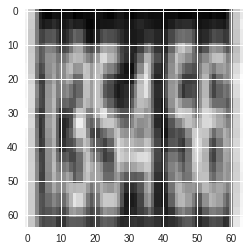

In [16]:
plt.imshow(train_dataset[29929,:,:])
print(train_labels[29929])

In [0]:
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)

In [18]:
print(train_dataset.shape)
print(train_labels.shape)

(33401, 64, 64)
(33401, 5)


#### Test dataset

In [19]:
test_dataset = Dataset(test_data, 'test')
test_dataset, test_labels = test_dataset.getDataset()

dataset: (13068, 64, 64)
labels: (13068, 5)


#### Validation Dataset

In [0]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

In [21]:
train_portion = 6000
valid_dataset = train_dataset[:train_portion,:,:]
valid_labels = train_labels[:train_portion]
train_dataset = train_dataset[train_portion:,:,:]
train_labels = train_labels[train_portion:]
                             
print(train_dataset.shape, train_labels.shape)
print(test_dataset.shape, test_labels.shape)
print(valid_dataset.shape, valid_labels.shape)

(27401, 64, 64) (27401, 5)
(13068, 64, 64) (13068, 5)
(6000, 64, 64) (6000, 5)


In [0]:
def disp_sample_dataset(dataset, label):
    items = random.sample(range(dataset.shape[0]), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(label[i][0:5])
        plt.imshow(dataset[i,:,:])

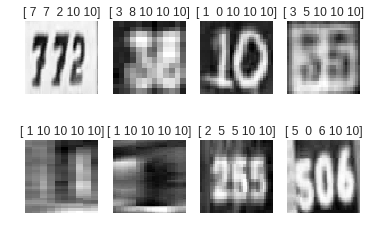

In [23]:
disp_sample_dataset(train_dataset, train_labels)

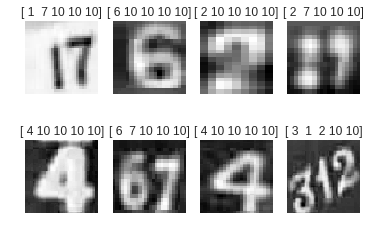

In [24]:
disp_sample_dataset(test_dataset, test_labels)

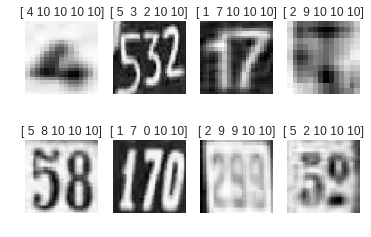

In [25]:
disp_sample_dataset(valid_dataset, valid_labels)

### Save dataset

In [26]:
pickle_file = 'SVHN_multi_crop.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print("Done")
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Done


In [27]:
pickle_file = 'SVHN_multi_crop_64.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    print("Done")
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Done


### Explore

In [28]:
pickle_file = 'SVHN_multi_crop.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (27401, 64, 64) (27401, 5)
Validation set (6000, 64, 64) (6000, 5)
Test set (13068, 64, 64) (13068, 5)


In [0]:
train_num_length = Counter(train_labels[:,0])
test_num_length = Counter(test_labels[:,0])
valid_num_length = Counter(valid_labels[:,0])

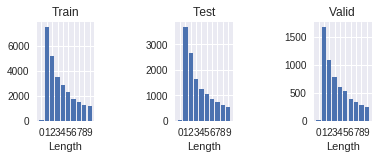

In [30]:
plt.figure()

plt.subplot(251)
plt.bar(train_num_length.keys(), train_num_length.values(), align='center')
plt.xticks(train_num_length.keys())
plt.title('Train')
plt.xlabel('Length')

plt.subplot(253)
plt.bar(test_num_length.keys(), test_num_length.values(), align='center')
plt.xticks(test_num_length.keys())
plt.title('Test')
plt.xlabel('Length')

plt.subplot(255)
plt.bar(valid_num_length.keys(), valid_num_length.values(), align='center')
plt.xticks(test_num_length.keys())
plt.title('Valid')
plt.xlabel('Length')

plt.show()

In [0]:
# Remove classes of empty labels
train_digits = Counter(train_labels.flatten()[np.where(train_labels.flatten() != 10)])
test_digits = Counter(test_labels.flatten()[np.where(test_labels.flatten() != 10)])
valid_digits = Counter(valid_labels.flatten()[np.where(valid_labels.flatten() != 10)])

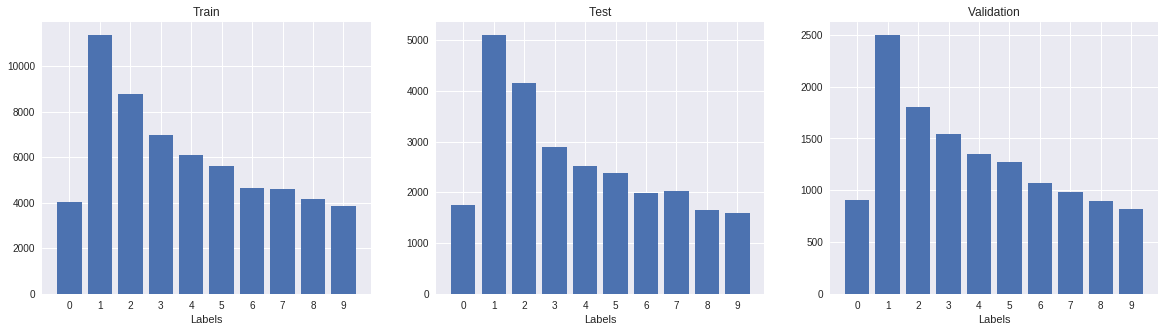

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.bar(train_digits.keys(), train_digits.values(), align='center')
ax1.set_xticks(train_digits.keys())
ax1.set_title('Train')
ax1.set_xlabel('Labels')

ax2.bar(test_digits.keys(), test_digits.values(), align='center')
ax2.set_xticks(test_digits.keys())
ax2.set_title('Test')
ax2.set_xlabel('Labels')

ax3.bar(valid_digits.keys(), valid_digits.values(), align='center')
ax3.set_xticks(valid_digits.keys())
ax3.set_title('Validation')
ax3.set_xlabel('Labels')

plt.show()

In [0]:
train_size = 33402
# valid_size = 6000
test_size = 13068

In [34]:
# def count_size(path)
train_height = []
train_width = []
for i in range(1, train_size):
    image_name = str(i) + '.png'
    fin = os.path.join('train',image_name)
    im = Image.open(fin)
    train_width.append(im.size[0])
    train_height.append(im.size[1])
print('Done')

Done


In [35]:
print(np.mean(train_height))
print(np.mean(train_width))
print(np.median(train_height))
print(np.median(train_width))
print(np.max(train_height))
print(np.min(train_height))
print(np.max(train_width))
print(np.min(train_width))

57.21349660189815
128.28544055567198
47.0
104.0
501
12
876
25


In [36]:
test_height = []
test_width = []
for i in range(1, test_size):
    image_name = str(i) + '.png'
    fin = os.path.join('test',image_name)
    im = Image.open(fin)
    test_width.append(im.size[0])
    test_height.append(im.size[1])
print('Done')

Done


In [37]:
print(np.mean(test_height))
print(np.mean(test_width))
print(np.median(test_height))
print(np.median(test_width))
print(np.max(test_height))
print(np.min(test_height))
print(np.max(test_width))
print(np.min(test_width))

71.56891405831485
172.58972985383025
53.0
132.0
516
13
1083
31


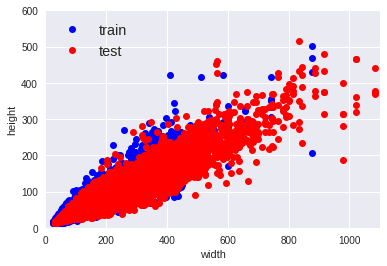

In [38]:
from numpy.random import rand

plt.xlim(xmax=1100,xmin=0)
plt.ylim(ymax=600,ymin=0)
plt.xlabel("width")
plt.ylabel("height")


path_1 = r'train'


x = train_width
y = train_height
plt.plot(x,y,'ro',color='blue',label='train')

path_2 = r'test'

x = test_width
y = test_height
plt.plot(x,y,'ro',color='red',label='test')


# legend
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.grid(True)

# display data
plt.show()

Source: https://ryannng.github.io/2016/12/20/Street-View-House-Numbers-Recognition-Using-ConvNets/